In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/preprocessed-raw-mat-csv/mat-csv-actual/mat-csv-actual/csv_files_from_mat2/02010030rest 20160324 1054..csv
/kaggle/input/preprocessed-raw-mat-csv/mat-csv-actual/mat-csv-actual/csv_files_from_mat2/02020025rest 20150713 1519..csv
/kaggle/input/preprocessed-raw-mat-csv/mat-csv-actual/mat-csv-actual/csv_files_from_mat2/02010013rest 20150703 1333..csv
/kaggle/input/preprocessed-raw-mat-csv/mat-csv-actual/mat-csv-actual/csv_files_from_mat2/02020016rest 20150701 1040..csv
/kaggle/input/preprocessed-raw-mat-csv/mat-csv-actual/mat-csv-actual/csv_files_from_mat2/02020015_rest 20150630 1527.csv
/kaggle/input/preprocessed-raw-mat-csv/mat-csv-actual/mat-csv-actual/csv_files_from_mat2/02010022restnew 20150724 14.csv
/kaggle/input/preprocessed-raw-mat-csv/mat-csv-actual/mat-csv-actual/csv_files_from_mat2/02020027rest 20150713 1049..csv
/kaggle/input/preprocessed-raw-mat-csv/mat-csv-actual/mat-csv-actual/csv_files_from_mat2/02010008_rest 20150619 1653.csv
/kaggle/input/preprocessed-raw-m

# **Import Libraries **

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# **Load & Preprocess Data**

In [5]:
# Cell 1: Load & Preprocess Data
import os
import pandas as pd
import numpy as np

# Path to .mat-preprocessed CSVs (change if needed)
directory_path = '/kaggle/input/preprocessed-raw-mat-csv/mat-csv-actual/mat-csv-actual/csv_files_from_mat2'

# Load + concatenate all CSVs
combined_data = pd.DataFrame()
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        data = pd.read_csv(file_path)
        combined_data = pd.concat([combined_data, data], ignore_index=True)

# Drop columns not used
for col in ['time', 'condition']:
    if col in combined_data.columns:
        combined_data = combined_data.drop(columns=[col])

# Map epoch labels to binary (keep mapping same as you used)
combined_data['epoch'] = combined_data['epoch'].map({1: 0, 2: 1})
combined_data = combined_data.dropna(subset=['epoch'])

# Features and target
X = combined_data.drop(columns=['epoch'])
y = combined_data['epoch'].astype(int)

# Sanity check
print("Data shape:", combined_data.shape)
print("Feature shape:", X.shape)
print("Target class counts:\n", y.value_counts())

Data shape: (25602, 130)
Feature shape: (25602, 129)
Target class counts:
 epoch
0    12801
1    12801
Name: count, dtype: int64


# **Define models and custom split ratios**

In [7]:
# Cell 2: Define models and split ratios
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(),
    'LDA': LinearDiscriminantAnalysis(),
    'Lasso': LogisticRegression(penalty='l1', solver='liblinear')
}

split_ratios = {
    'KNN': 0.1,
    'SVM': 0.2,
    'Random Forest': 0.2,
    'Decision Tree': 0.1,
    'XGBoost': 0.2,
    'Logistic Regression': 0.3,
    'LDA': 0.2,
    'Lasso': 0.1
}

# Keep these fixed (colors + output directory)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta']
output_dir = "/kaggle/working"
os.makedirs(output_dir, exist_ok=True)

print("Models defined:", list(models.keys()))


Models defined: ['KNN', 'SVM', 'Random Forest', 'Decision Tree', 'XGBoost', 'Logistic Regression', 'LDA', 'Lasso']


# **Prepare plots + train all models once and cache results**

In [8]:
# Cell 3: Train all models (with their custom splits) and cache results
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, roc_auc_score
)

results = {}   # store per-model: X_test, y_test, y_pred, y_proba, acc, report, cm, fpr, tpr, roc_auc, learning_curve_data

for i, (model_name, model) in enumerate(models.items()):
    test_size = split_ratios[model_name]
    print(f"\nTraining {model_name} with test_size={test_size} ...")

    # consistent split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    # standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # fit
    model.fit(X_train_scaled, y_train)

    # predictions
    y_pred = model.predict(X_test_scaled)
    # predict_proba fallback if not available
    try:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    except Exception:
        # some models might not implement predict_proba (but SVC has probability=True)
        try:
            # decision function -> convert to probabilities using sigmoid-ish mapping
            df = model.decision_function(X_test_scaled)
            # map to 0-1 via logistic
            from scipy.special import expit
            y_proba = expit(df)
        except Exception:
            y_proba = None

    acc = accuracy_score(y_test, y_pred)
    report_text = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # ROC
    if y_proba is not None and len(np.unique(y_test)) > 1:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        fpr = tpr = roc_auc = None

    # Learning curve (train vs validation) using 5-fold StratifiedKFold
    try:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        train_sizes, train_scores, valid_scores = learning_curve(
            estimator=model,
            X=X_train_scaled,
            y=y_train,
            cv=cv,
            scoring='accuracy',
            n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 5),
            shuffle=True,
            random_state=42
        )
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        valid_mean = np.mean(valid_scores, axis=1)
        valid_std = np.std(valid_scores, axis=1)
        lc = {
            'train_sizes': train_sizes,
            'train_mean': train_mean,
            'train_std': train_std,
            'valid_mean': valid_mean,
            'valid_std': valid_std
        }
    except Exception as e:
        print(f"Learning-curve error for {model_name}: {e}")
        lc = None

    results[model_name] = {
        'model': model,
        'X_test': X_test_scaled,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'acc': acc,
        'report_text': report_text,
        'cm': cm,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'learning_curve': lc
    }

    print(f"{model_name} done — acc: {acc:.4f}, roc_auc: {roc_auc if roc_auc is not None else 'N/A'}")

# quick check
print("\nTrained models:", list(results.keys()))


Training KNN with test_size=0.1 ...
KNN done — acc: 0.9793, roc_auc: 0.9984771418813427

Training SVM with test_size=0.2 ...
SVM done — acc: 0.8541, roc_auc: 0.9480146915267476

Training Random Forest with test_size=0.2 ...
Random Forest done — acc: 0.9805, roc_auc: 0.9986055099326435

Training Decision Tree with test_size=0.1 ...
Decision Tree done — acc: 0.9118, roc_auc: 0.9117498536299766

Training XGBoost with test_size=0.2 ...
XGBoost done — acc: 0.9744, roc_auc: 0.9976820272842639

Training Logistic Regression with test_size=0.3 ...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression done — acc: 0.8159, roc_auc: 0.9119630304608175

Training LDA with test_size=0.2 ...
LDA done — acc: 0.7998, roc_auc: 0.8955746961636079

Training Lasso with test_size=0.1 ...
Lasso done — acc: 0.8247, roc_auc: 0.9181321965261515

Trained models: ['KNN', 'SVM', 'Random Forest', 'Decision Tree', 'XGBoost', 'Logistic Regression', 'LDA', 'Lasso']


# **ROC-specific: single combined ROC plot (all models in one image)**

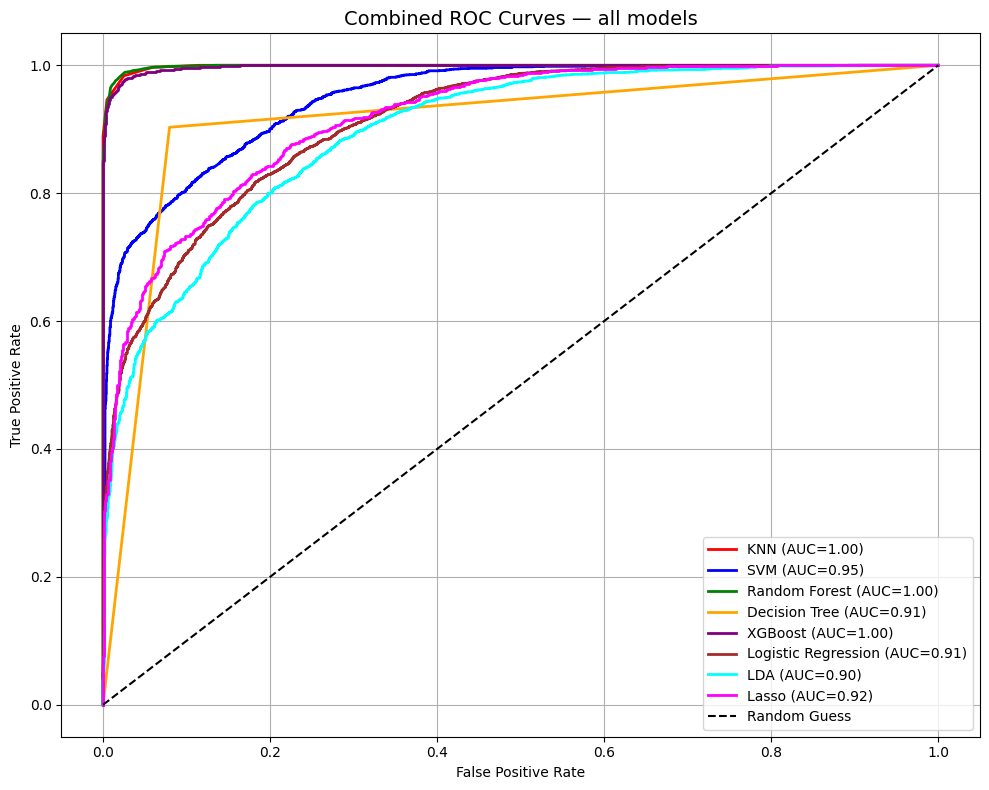

Saved ROC combined: /kaggle/working/roc_curves_all_models_combined.png


In [9]:
# Cell 4: ROC-specific combined plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))

for i, (model_name, res) in enumerate(results.items()):
    if res['fpr'] is None:
        # skip models where we couldn't compute probabilities
        continue
    ax.plot(res['fpr'], res['tpr'], color=colors[i % len(colors)],
            label=f"{model_name} (AUC={res['roc_auc']:.2f})", linewidth=2)

# Random guess line
ax.plot([0,1], [0,1], 'k--', label='Random Guess')

ax.set_title("Combined ROC Curves — all models", fontsize=14)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc='lower right')
ax.grid(True)

roc_path = os.path.join(output_dir, "roc_curves_all_models_combined.png")
fig.tight_layout()
fig.savefig(roc_path)
plt.show()
print("Saved ROC combined:", roc_path)

# **Classification-report specific: one image containing all models' reports**

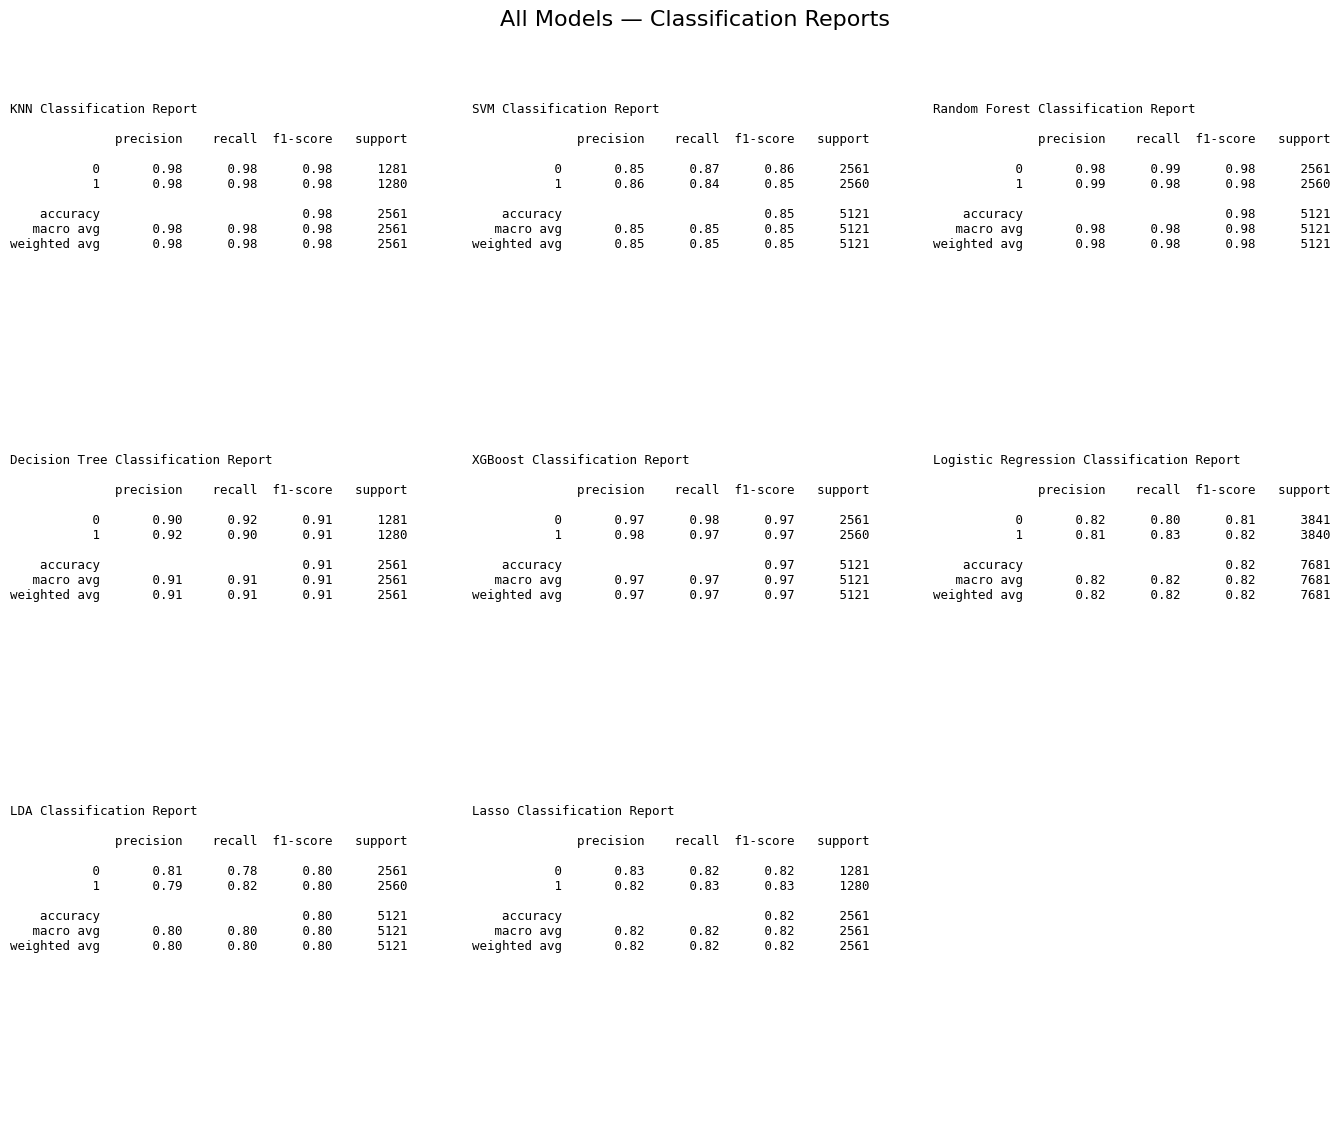

Saved all classification reports: /kaggle/working/all_models_classification_reports.png


In [10]:
# Cell 5: Classification-report specific — all reports into one grid image
import matplotlib.pyplot as plt

n_models = len(results)
ncols = 3
nrows = int(np.ceil(n_models / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4 * nrows))
axes = axes.ravel()

for idx, (model_name, res) in enumerate(results.items()):
    ax = axes[idx]
    ax.axis('off')
    text = f"{model_name} Classification Report\n\n{res['report_text']}"
    ax.text(0, 0.98, text, fontsize=9, va='top', family='monospace')

# remove unused axes
for j in range(idx+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("All Models — Classification Reports", fontsize=16)
report_img_path = os.path.join(output_dir, "all_models_classification_reports.png")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(report_img_path)
plt.show()
print("Saved all classification reports:", report_img_path)

# **Confusion-matrix specific: grid of heatmaps (1 image)**

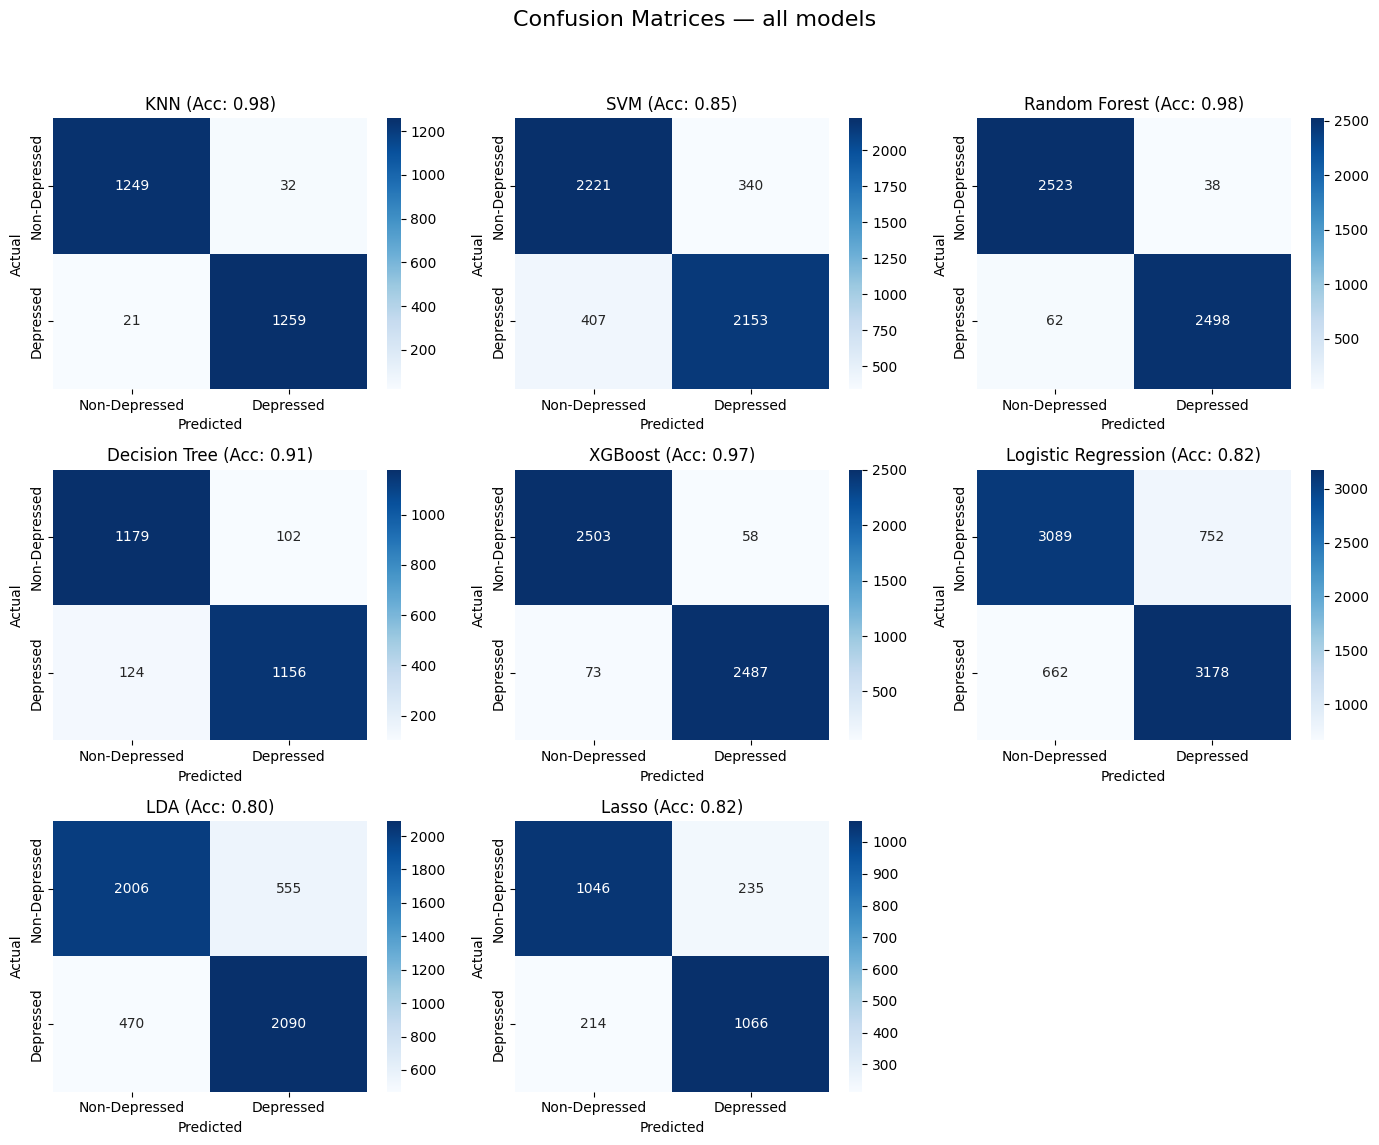

Saved confusion matrices: /kaggle/working/confusion_matrices_all_models.png


In [12]:
# Cell 6: Confusion-matrix specific (grid)
import seaborn as sns
import matplotlib.pyplot as plt

n_models = len(results)
ncols = 3
nrows = int(np.ceil(n_models / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4 * nrows))
axes = axes.ravel()

for idx, (model_name, res) in enumerate(results.items()):
    ax = axes[idx]
    cm = res['cm']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Non-Depressed', 'Depressed'],
                yticklabels=['Non-Depressed', 'Depressed'])
    ax.set_title(f"{model_name} (Acc: {res['acc']:.2f})")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# remove unused axes
for j in range(idx+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Confusion Matrices — all models", fontsize=16)
conf_img_path = os.path.join(output_dir, "confusion_matrices_all_models.png")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(conf_img_path)
plt.show()
print("Saved confusion matrices:", conf_img_path)

# **Train-validation (learning) curves specific: grid with one panel per mode**

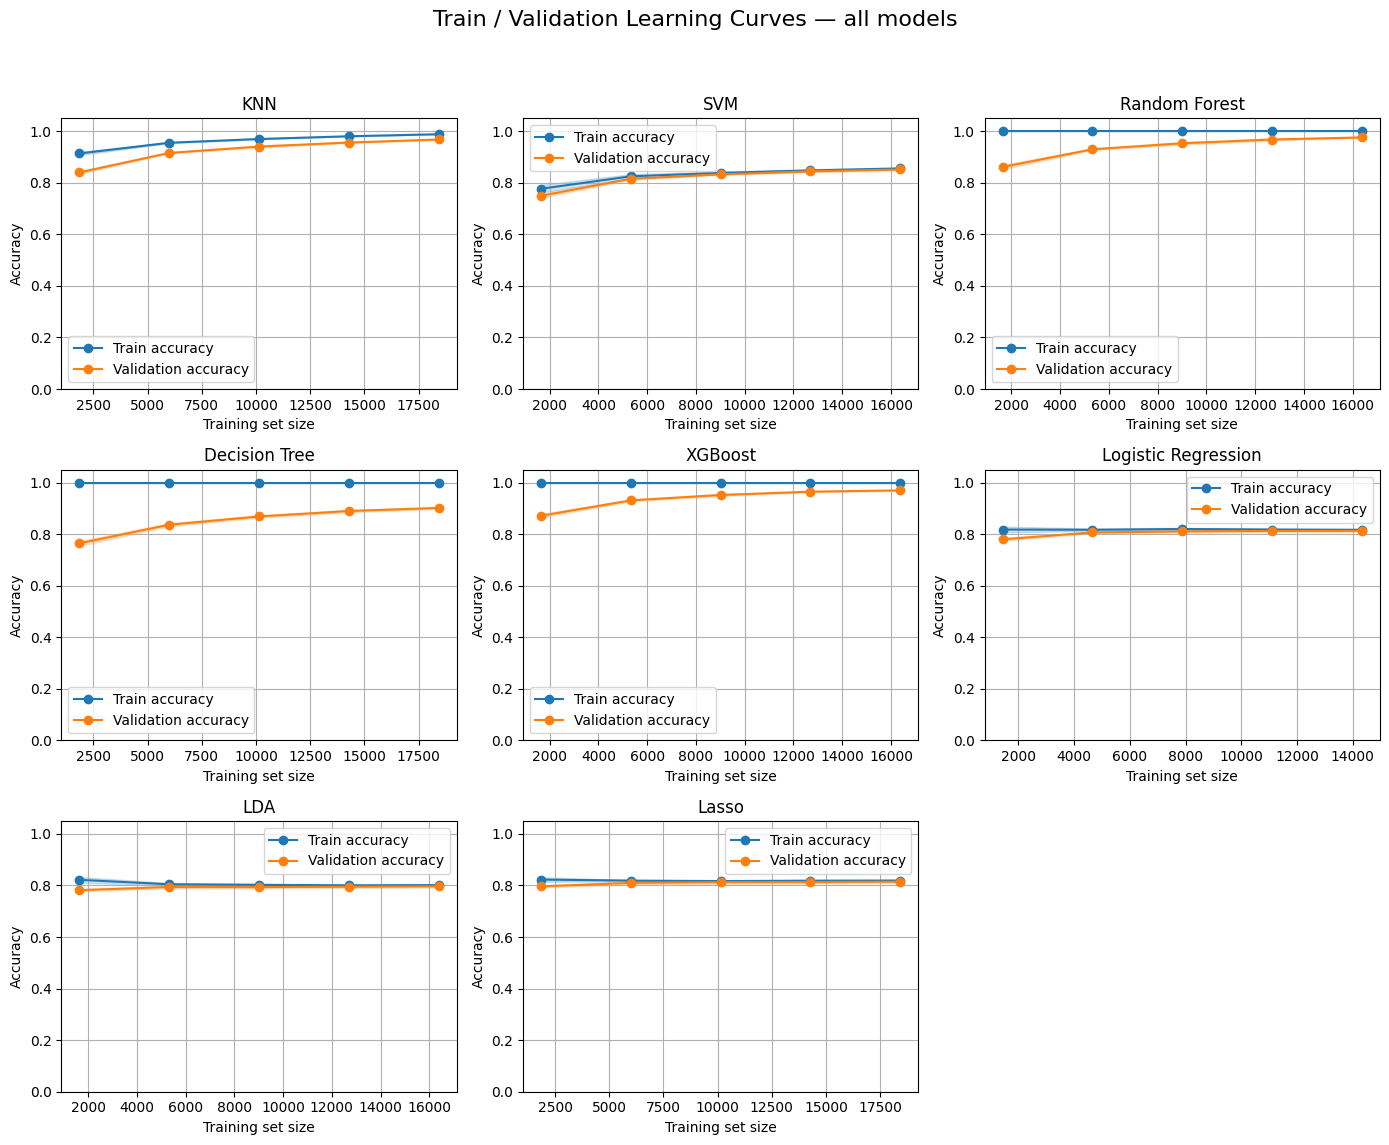

Saved learning curves image: /kaggle/working/learning_curves_all_models.png


In [11]:
# Cell 7: Train-validation (learning curves) specific (grid)
import matplotlib.pyplot as plt

n_models = len(results)
ncols = 3
nrows = int(np.ceil(n_models / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4 * nrows))
axes = axes.ravel()

for idx, (model_name, res) in enumerate(results.items()):
    ax = axes[idx]
    lc = res['learning_curve']
    if lc is None:
        ax.text(0.5, 0.5, 'Learning curve not available', ha='center', va='center')
        ax.set_title(model_name)
        ax.axis('off')
        continue

    train_sizes = lc['train_sizes']
    ax.plot(train_sizes, lc['train_mean'], label='Train accuracy', color='tab:blue', marker='o')
    ax.fill_between(train_sizes, lc['train_mean'] - lc['train_std'], lc['train_mean'] + lc['train_std'],
                    alpha=0.2, color='tab:blue')

    ax.plot(train_sizes, lc['valid_mean'], label='Validation accuracy', color='tab:orange', marker='o')
    ax.fill_between(train_sizes, lc['valid_mean'] - lc['valid_std'], lc['valid_mean'] + lc['valid_std'],
                    alpha=0.2, color='tab:orange')

    ax.set_xlabel('Training set size')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'{model_name}')
    ax.set_ylim(0.0, 1.05)
    ax.grid(True)
    ax.legend()

# remove unused axes
for j in range(idx+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Train / Validation Learning Curves — all models", fontsize=16)
learn_img_path = os.path.join(output_dir, "learning_curves_all_models.png")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(learn_img_path)
plt.show()
print("Saved learning curves image:", learn_img_path)